# Perkenalan

# Import Library

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Data Loading

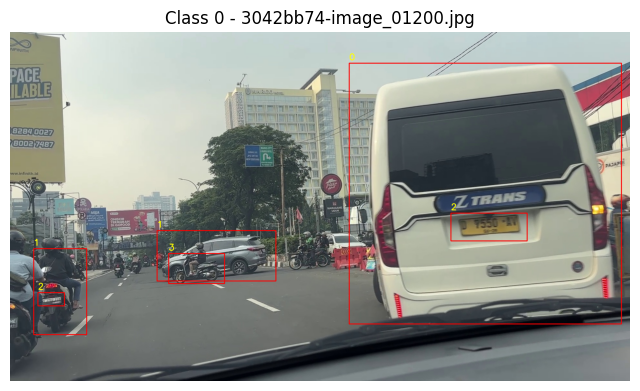

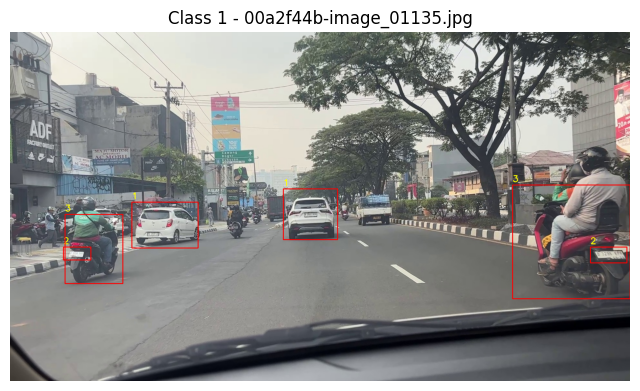

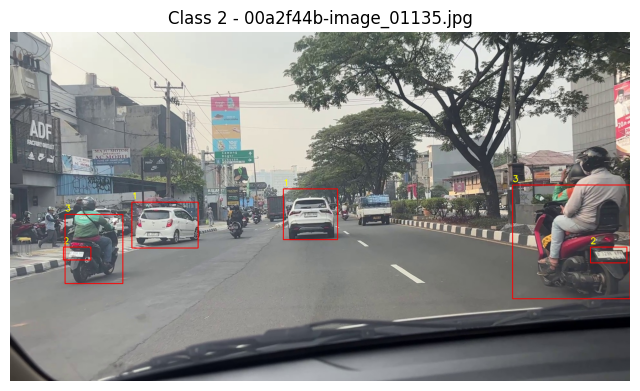

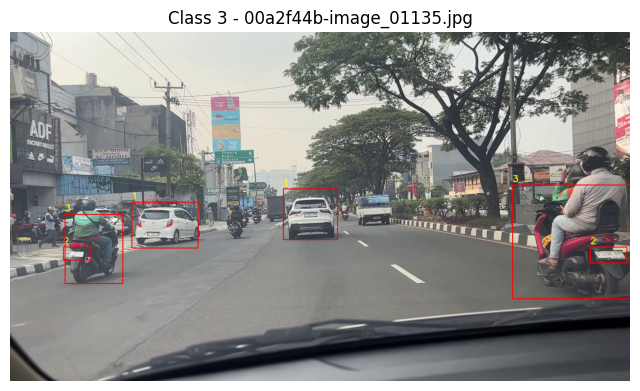

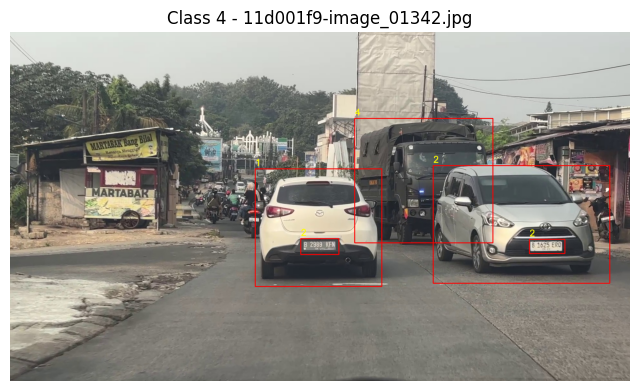

In [3]:
images_dir = 'data/train/images'
labels_dir = 'data/train/labels'

# Target 12 class
num_classes = 12
class_examples = dict()  # Simpan image_file per class

# List semua file gambar
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Cari 1 contoh per class
for image_file in image_files:
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])

            if class_id not in class_examples and class_id < num_classes:
                class_examples[class_id] = image_file

    # Stop lebih cepat kalau sudah ketemu semua
    if len(class_examples) == num_classes:
        break

# Sekarang tampilkan semua contoh (1 gambar per class)
for class_id in sorted(class_examples.keys()):
    image_file = class_examples[class_id]
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Load bbox
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cid = int(parts[0])
            x_center = float(parts[1]) * w
            y_center = float(parts[2]) * h
            width = float(parts[3]) * w
            height = float(parts[4]) * h

            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)

            boxes.append((cid, xmin, ymin, xmax, ymax))

    # Draw bbox dan label
    for box in boxes:
        cid, xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        label_text = str(cid)
        cv2.putText(image, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (255, 255, 0), 2)

    # Tampilkan image untuk class_id ini
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Class {class_id} - {image_file}")
    plt.axis('off')
    plt.show()

# Exploratory Data Analysis

In [ ]:
# EDA 1

In [ ]:
# EDA 2

In [ ]:
# EDA 3

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

images_dir = 'valid/images'
labels_dir = 'valid/labels'

# Baca semua annotation jadi DataFrame
records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    # Dummy size assumption (karena YOLO pakai normalized)
    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

# 1️⃣ Distribusi jumlah objek per class
plt.figure(figsize=(8,4))
sns.countplot(x='class_id', data=df)
plt.title('Distribusi Jumlah Objek per Class')
plt.show()

# 2️⃣ Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

# 3️⃣ Distribusi ukuran bbox (area)
plt.figure(figsize=(8,4))
sns.histplot(df['area'], bins=20, kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

# 4️⃣ Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

# 5️⃣ Visualisasi 5 gambar random + bbox
import cv2
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

# 6️⃣ Heatmap sebaran posisi centroid bbox
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()

# 7️⃣ Proporsi persentase class
class_counts = df['class_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Proporsi Persentase Class')
plt.ylabel('Persentase (%)')
plt.show()


In [ ]:
# !pip install ultralytics

In [10]:
from ultralytics import YOLO

# Load model YOLOv8 pretrained (misal YOLOv8n = nano, bisa diganti v8s/v8m/v8l)
model = YOLO('yolov8n.pt')

# Train
model.train(
    data='data.yaml',     # path ke file yaml dataset kamu
    epochs=20,            # jumlah epoch training
    batch=16,             # ukuran batch
    imgsz=640,            # ukuran gambar
    device=0          # 0 = GPU, 'cpu' = CPU
)


New https://pypi.org/project/ultralytics/8.3.165 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.163  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=Fal

100%|██████████| 5.35M/5.35M [00:00<00:00, 8.14MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 44.68.1 MB/s, size: 618.2 KB)


train: Scanning C:\Users\ASUS\Hacktiv8\Phase 2\Final Project\data\train\labels... 288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 288/288 [00:00<00:00, 477.71it/s]

train: New cache created: C:\Users\ASUS\Hacktiv8\Phase 2\Final Project\data\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 47.511.8 MB/s, size: 550.9 KB)


val: Scanning C:\Users\ASUS\Hacktiv8\Phase 2\Final Project\data\validation\labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 252.81it/s]

val: New cache created: C:\Users\ASUS\Hacktiv8\Phase 2\Final Project\data\validation\labels.cache


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.01G      1.634      3.278      1.377        138        640: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         73        298       0.02      0.751      0.364       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.05G      1.461      1.764      1.168        144        640: 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         73        298       0.96      0.171      0.413      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.02G      1.335      1.425      1.122        115        640: 100%|██████████| 18/18 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         73        298      0.843      0.179      0.241      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.97G      1.309      1.351      1.122         96        640: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


                   all         73        298      0.903      0.308      0.502      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.04G      1.319      1.294      1.119        156        640: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         73        298      0.903      0.405      0.573      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.97G      1.269      1.237      1.105        119        640: 100%|██████████| 18/18 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         73        298      0.782      0.676      0.743      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.99G      1.234      1.135      1.086        168        640: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         73        298      0.782      0.619      0.721      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.98G      1.223      1.091      1.089        131        640: 100%|██████████| 18/18 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         73        298       0.87      0.747      0.829      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.98G      1.213      1.088      1.069        121        640: 100%|██████████| 18/18 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         73        298       0.86      0.774      0.859       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.05G      1.198      1.035      1.079        125        640: 100%|██████████| 18/18 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         73        298      0.744       0.86      0.873      0.597


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.93G      1.194      1.186      1.074         79        640: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         73        298      0.743      0.876      0.872      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.95G      1.152      1.073      1.046         62        640: 100%|██████████| 18/18 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         73        298      0.755      0.826       0.85      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.97G      1.147      1.059      1.053         80        640: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         73        298      0.869      0.846      0.894      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.98G      1.122     0.9978      1.033         60        640: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         73        298      0.797      0.875      0.893      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         2G      1.115     0.9794      1.041         59        640: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         73        298      0.709      0.926      0.877      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.97G      1.101      0.952      1.034         59        640: 100%|██████████| 18/18 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         73        298      0.819      0.794       0.88      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.97G      1.088     0.9257      1.024         67        640: 100%|██████████| 18/18 [00:04<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         73        298      0.849      0.848      0.921      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.98G      1.072     0.8972      1.019         68        640: 100%|██████████| 18/18 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all         73        298      0.792      0.903      0.921       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         2G      1.064     0.8944      1.012         69        640: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         73        298      0.904      0.864      0.931      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.97G      1.035     0.8777      1.004         57        640: 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         73        298      0.889      0.831      0.935      0.632



20 epochs completed in 0.035 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.163  Python-3.9.23 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


                   all         73        298      0.889      0.834      0.935      0.632
                   Car         48         76      0.844      0.855      0.934      0.722
          LicensePlate         59         98      0.956      0.664        0.9      0.515
            Motorcycle         56        119       0.89      0.817      0.911      0.596
                 Truck          5          5      0.865          1      0.995      0.696
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D6E7B21B20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       